In [1]:
## 2024 aPC flavor & hedonic testing

## import packages

import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
import pandas as pd
import pynapple as nap
%matplotlib inline
%config InlineBackend.figure_format = 'svg'


/opt/anaconda3/envs/pynapple/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/opt/anaconda3/envs/pynapple/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/opt/anaconda3/envs/pynapple/lib/python3.11/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


In [2]:
def datetime_convert_phenosys(csv_path):
    ## Def phensys converter for lick rate
    def timestampconvert(x):
        stamp = datetime.timedelta(days = x)
        result = datetime.datetime(1899,12,30,0,0) + stamp
        # print(result.strftime('%Y-%m-%d %H:%M:%S.%f'))
        return result
    
    df_pheno = pd.read_csv(csv_path,sep=',')
    time_list = df_pheno['DateTime']
    result = []
    for x in time_list:
        timestampconvert(float(x))
        result.append(timestampconvert(x))
    new_time_stamps = []
    for i in result:
        new_time_stamps.append((i-min(result)).total_seconds())
    df_pheno = df_pheno.fillna(0)
    df_pheno['DateTime'] = new_time_stamps
    # df_pheno
    return df_pheno


## Function for getting Pump events
def Pump_event_calculate_P1_all(csv_path):
    """
    This function will calcuate the lick sensor data from the phenosys csv files and return 3 lists of timestamps from GPIOs P1 and P1C and the timestamps of both channels.

    """
    df = datetime_convert_phenosys(csv_path)
    
    # Get L1 timestamps and MsgValue1
    P1_time = df[df['unitLabel']=='P1']['DateTime'].values
    P1_time = P1_time[P1_time>5]
    P1C_time = df[df['unitLabel']=='P1C']['DateTime'].values
    P1C_time = P1C_time[P1C_time>5]
    P1D_time = df[df['unitLabel']=='P1D']['DateTime'].values 
    P1D_time = P1D_time[P1D_time>5]

    # all_pump_events = P1_time + P1C_time + P2_time + P2A_time
    Pump_all = np.concatenate([P1_time,P1C_time,P1D_time],axis=0)
    Pump_all = sorted(Pump_all)
    Pump_all = np.array(Pump_all)
    
    return P1_time, P1C_time, P1D_time, Pump_all


## Function for getting L1 and L2 lick events
def lick_event_calculate(csv_path):
    """
    This function will calcuate the lick sensor data from the phenosys csv files and return 3 lists of timestamps from sensor L1, L2 and the timestamps of both channels. It will also do a quick plotting for the lick sensor data for raster plots and the density plot of overall lick events.

    """
    df = datetime_convert_phenosys(csv_path)
    
    # Get L1 timestamps and MsgValue1
    L1_time = df[df['unitLabel']=='L1']['DateTime'].values
    L1_value = df[df['unitLabel']=='L1']['MsgValue1'].values
    L1_timestamps_new = []

    # loop through each L1 value, if it has more than 1 value meaning more licks are packed here
    for idx,value in enumerate(L1_value):
        # check if >1 licks are packed in this row
        if len(value.split(','))>1:
            # loop through individual licks packed in this row
            for idx_j,j in enumerate(value.split(',')):
                if idx_j == 0:
                    # get time from L1_time[idx] directly since this is the first lick
                    L1_timestamps_new.append(L1_time[idx])
                else:
                    # get the first value of the lick events, meaning the time difference since the last lick "onset", note it's not the gap between these 2 lick events
                    individual_value = int(j.split('-')[0])*0.001 # convert ms to s
                    # add the time difference (individual_value) to the last timestamp in the array (last lick timestamp)
                    L1_timestamps_new.append(L1_timestamps_new[-1]+individual_value)
        else:
            # only 1 lick event in this row, directly save the timestamp
            L1_timestamps_new.append(L1_time[idx])
    L1_timestamps_new = np.array(L1_timestamps_new)

    ## The same for L2
    L2_time = df[df['unitLabel']=='L2']['DateTime'].values
    L2_value = df[df['unitLabel']=='L2']['MsgValue1'].values
    L2_timestamps_new = []
    
    # loop through each L1 value, if it has more than 1 value meaning more licks are packed here
    for idx,value in enumerate(L2_value):
        # check if >1 licks are packed in this row
        if len(value.split(','))>1:
            # loop through individual licks packed in this row
            for idx_j,j in enumerate(value.split(',')):
                if idx_j == 0:
                    # get time from L1_time[idx] directly since this is the first lick
                    L2_timestamps_new.append(L2_time[idx])
                else:
                    # get the first value of the lick events, meaning the time difference since the last lick "onset", note it's not the gap between these 2 lick events
                    individual_value = int(j.split('-')[0])*0.001 # convert ms to s
                    # add the time difference (individual_value) to the last timestamp in the array (last lick timestamp)
                    L2_timestamps_new.append(L2_timestamps_new[-1]+individual_value)
        else:
            # only 1 lick event in this row, directly save the timestamp
            L2_timestamps_new.append(L2_time[idx])
    L2_timestamps_new = np.array(L2_timestamps_new)

    all_lick_events = np.array(sorted([*L1_timestamps_new,*L2_timestamps_new]))

    return L1_timestamps_new, L2_timestamps_new, all_lick_events

In [3]:
## burst detection function from other ppl, adapted from the following link
## https://spikesandbursts.wordpress.com/2023/08/24/patch-clamp-data-analysis-in-python-bursts/
def burst_detection(df, spike_times,
                    n_spikes, 
                    max_isi, 
                    # min_duration,  # Optional
                    min_ibi):
     
    """
    Detects bursts in spike data based on spike times, 
    by identifying consecutive spikes that fulfill the criteria of:
    minimum number of spikes, maximum interspike interval, and minimum interburst interval.
     
    Arguments: 
        df: DataFrame with spike data.
        spike_times: Column name for spike positions.
        spike_amplitudes: Column name for spike amplitudes.
        spike_peaks: Column name for spike peak amplitudes. 
        n_spikes: Minimum number of spikes within a burst.
        max_isi: Max interspike interval within the burst.
        min_duration: Minimum burst duration.
        min_ibi: Minimum interburst interval (optional).
         
    Returns:
        DataFrame with burst information.
    """
     
    df = df.sort_values(by=spike_times)  # Sort DataFrame by spike positions
    df['burst'] = np.nan  # Create column for burst labels
    burst_num = 0        # Initialize burst number
    burst_start = None   # Initialize burst start position
    last_spike = None    # Initialize last spike position
 
    for i, row in df.iterrows():  # Loop through DataFrame rows 
        spike = row[spike_times]   # Extract the spike position 
         
        if burst_start is None:   # It checks if it is the first spike 
            burst_start = spike   # It marks the current spike position as the start of a burst
            last_spike = spike    # Update the last_spike position to the current spike position
            df.at[i, 'burst'] = burst_num   # Assign burst number
        elif spike - last_spike <= max_isi:  # It checks if the current spike is within max isi
            df.at[i, 'burst'] = burst_num  
            last_spike = spike 
        elif spike - last_spike > min_ibi:  # It checks if the interburst interval has been reached
            burst_num += 1 
            burst_start = spike 
            last_spike = spike  
            df.at[i, 'burst'] = burst_num
     
    # Filter bursts with less than min_spikes
    df = df[df.groupby('burst')[spike_times].transform('count') >= n_spikes]
     
    # Filter burst shorter that min_duration (min_duration parameter)
    # df = df[df.groupby('burst')[spike_times].transform('max') 
    #         - df.groupby('burst')[spike_times].transform('min')
    #         >= min_duration]
     
    # Calculate burst information by aggregating single spike information
    bursts = df.groupby('burst')[spike_times].agg(['min', 'max', 'count'])
    bursts.columns = ['burst_start', 'burst_end', 'spikes_in_bursts']
    bursts['burst_length'] = bursts['burst_end'] - bursts['burst_start']
    # bursts['avg_spike_amplitude'] = df.groupby('burst')[spike_amplitudes].mean()
    # bursts['avg_spike_peaks'] = df.groupby('burst')[spike_peaks].mean()  
    bursts['spikes_frequency'] = bursts['spikes_in_bursts'] / bursts['burst_length']
    bursts = bursts.reset_index()
    bursts['burst_number'] = bursts.index + 1
     
    return bursts[['burst_number', 'burst_start', 'burst_end', 
                   'burst_length', 'spikes_in_bursts', 'spikes_frequency']]

## new detection function that used the above function
def detect_binge_bout(Pump_event, n_pumps, max_isi, min_ibi):
    df = pd.DataFrame(Pump_event,columns=['spike_times'])
    binge_df = burst_detection(df=df,spike_times='spike_times', 
                             n_spikes = n_pumps,  
                             max_isi = max_isi,
                             min_ibi = min_ibi)
    binge_df = binge_df.rename(columns={"burst_number":"binge_bout_idx",
                                    "burst_start":"start",
                                    "burst_end":"end",
                                    "burst_length":"bout_duration",
                                    "spikes_in_bursts":"deliveries_in_bout",
                                    "spikes_frequency":"delivery_frequency"})
    
    return binge_df, nap.IntervalSet(start= binge_df['start'],end=binge_df['end'])

/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_42962/550236136.py:43: UserWarning: Some starts and ends are equal. Removing 1 microsecond!
  mouse_switch_set = nap.IntervalSet(end=list(mice_switch[1:].values)+[df_pheno['DateTime'].max()],start=[0]+list(mice_switch[1:].values))


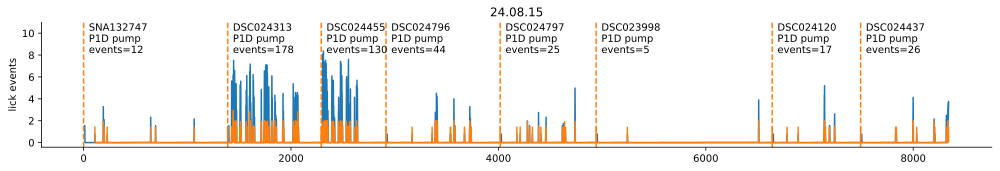

In [35]:
# csv_path = '/Users/hunglo/Downloads/DSC024312_training_Inscopix-24.08.07_.csv'
# csv_path = '/Users/hunglo/Downloads/Training_Inscopix-24.08.12_.csv'
# csv_path = '/Users/hunglo/Downloads/Training_Inscopix-24.08.13_.csv'
# csv_path = '/Users/hunglo/Downloads/Training_Inscopix-24.08.14_.csv'

csv_path = '/Users/hunglo/Downloads/Training_Inscopix-24.08.15_.csv'
# csv_path = '/Users/hunglo/Downloads/Training_Inscopix-24.08.16_.csv'

date = csv_path.split('Inscopix-')[-1].split('_.csv')[0]

P1_time, P1C_time, P1D_time, Pump_all = Pump_event_calculate_P1_all(csv_path=csv_path)
L1_timestamps_new, L2_timestamps_new, all_lick_events = lick_event_calculate(csv_path=csv_path)

# mice_list = ['SNA132750-ACh','SNA132751-NE','DSC024309-BF','DSC024287-BF->aPC']
# mice_list = ['SNA132752-eCB','SNA132753-Opioids']
# mice_list = ['DSC024312']
# mice_list = ['DSC024796','DSC024455','DSC024313']

# 15.08 onwards
mice_list = ['SNA132747',
             'DSC024313',
             'DSC024455',
             'DSC024796',
             'DSC024797',
             'DSC023998',
             'DSC024120',
             'DSC024437',
             ]

bin_size = 0.25 # sec

plt.figure(figsize=[14,2.5])
plt.plot(nap.Ts(L1_timestamps_new).count(bin_size).smooth(bin_size*2)/bin_size)
plt.plot(nap.Ts(P1D_time).count(bin_size).smooth(bin_size*2)/bin_size)
plt.ylabel('lick events')
plt.title(date)
df_pheno = datetime_convert_phenosys(csv_path)
xlsx_list = [s for s in df_pheno['MsgValue1'].unique() if 'xlsx' in str(s)]
mice_switch = df_pheno[df_pheno['MsgValue1']==xlsx_list[0]]['DateTime'] # multiple mice's data in a same file
for i in mice_switch:
    plt.axvline(x=i,ls='dashed',c='C1')

mouse_switch_set = nap.IntervalSet(end=list(mice_switch[1:].values)+[df_pheno['DateTime'].max()],start=[0]+list(mice_switch[1:].values))
for i in range(len(mouse_switch_set)):
    plt.text(s=f'{mice_list[i]}\nP1D pump\nevents={len(nap.Ts(P1D_time).restrict(mouse_switch_set[i]))}',x=mice_switch.iloc[i]+50,y=8,va='bottom')

plt.ylim(ymax=11)
sns.despine()
plt.tight_layout()


In [15]:
## detect feeding bouts with lick events
interval = 3
lick_df, lick_epoch = detect_binge_bout(Pump_event=L1_timestamps_new,
                            n_pumps = 3, # min of pump events in one binge bout  
                            max_isi = interval,
                            min_ibi = interval)

lick_epoch

## can also drop shor or long bouts
## drop shorter bouts <2 s 
# bout_size = 2
# lick_epoch = lick_epoch.drop_short_intervals(bout_size, time_units='s')
# lick_epoch

## you can also do drop_long_intervals with same inputs

           start     end
0         189.96   191.016
1         197.063  198.545
2         646.932  647.253
3         1066.3   1066.79
4         1427.37  1460.72
5         1470.24  1471.48
6         1475.09  1475.6
          ...
52        7139.89  7145.59
53        7192.05  7194.64
54        7241.07  7242.68
55        7998.15  7999.64
56        8201.24  8201.86
57        8318.7   8320.06
58        8332.31  8341.15
shape: (59, 2), time unit: sec.

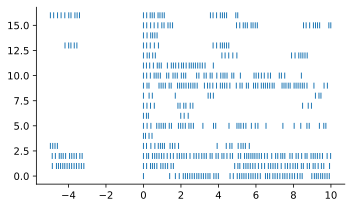

In [30]:
## compute PETH for licking bouts
## limited to certain mouse for example plotting

mouse = 2
mouse_switch_set[mouse]

Ts_lick = nap.Ts(L1_timestamps_new) # for tref this needs to be nap.Ts object
peth = nap.compute_perievent(Ts_lick,tref=nap.Ts(lick_epoch.start).restrict(mouse_switch_set[mouse]),minmax=(-5,10))
plt.figure(figsize=[5,3])
# for idx in peth.index:
#     plt.eventplot(peth[idx].t,lineoffsets=idx)
plt.plot(peth.to_tsd(), "|") # convert peth(TsGroup) to a flatten object for plotting
sns.despine()
plt.tight_layout()
plt.show()


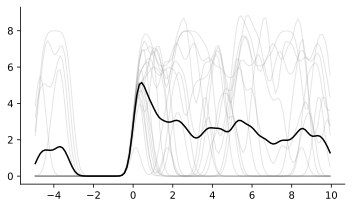

In [31]:
bin_size = 0.125
plt.figure(figsize=[5,3])
plt.plot(peth.count(bin_size).smooth(bin_size*2)/bin_size,alpha=0.2,c='grey',lw=1)
plt.plot((peth.count(bin_size).smooth(bin_size*2)/bin_size).mean(axis=1),label='mean lick rate',c='k')
sns.despine()
plt.tight_layout()

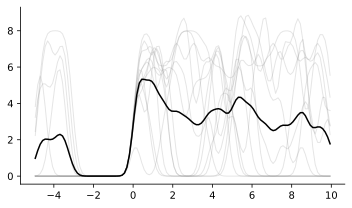

In [32]:
## one can also set a threshold on the overall lick rates for each trials

threshold = 1 # filter only trials with high values
op = '>' # greater
bin_size = 0.125

plt.figure(figsize=[5,3])
plt.plot(peth.getby_threshold('rate',threshold,op=op).count(bin_size).smooth(bin_size*2)/bin_size,alpha=0.2,c='grey',lw=1)
plt.plot((peth.getby_threshold('rate',threshold,op=op).count(bin_size).smooth(bin_size*2)/bin_size).mean(axis=1),label='mean lick rate',c='k')
sns.despine()
plt.tight_layout()

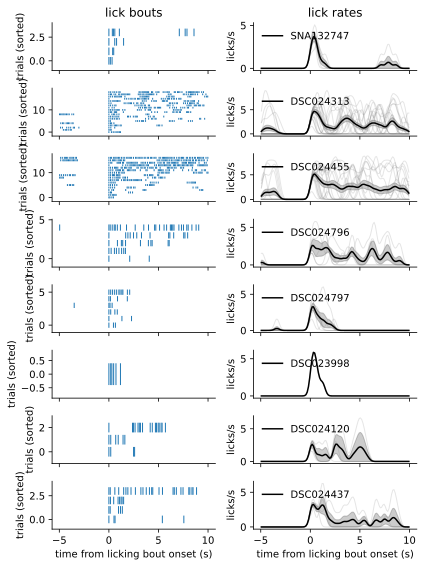

In [34]:
## plt all mice lick events together

## for converting peth TsGroup object to long dataframe for seaborn plotting
def peth2df_long(peth):
    timestamps = peth.times(units='s')
    data = peth.to_numpy()
    df = pd.DataFrame(data=data,index=timestamps).rename_axis('Time (s)')
    df_long = df.reset_index().melt(var_name='idx',value_name='lick rate',id_vars='Time (s)')

    return df_long

bin_size = 0.125

fig, axes = plt.subplots(nrows=len(mouse_switch_set),ncols=2,figsize=[6,8],sharex=True)

Ts_lick = nap.Ts(L1_timestamps_new) # for tref this needs to be nap.Ts object

for i in mouse_switch_set.index[:]:
    peth = nap.compute_perievent(Ts_lick,tref=nap.Ts(lick_epoch.start).restrict(mouse_switch_set[i]),minmax=(-5,10))
    # if we want to plot with sorting
    sort_idx = np.argsort([len(peth[i]) for i in peth.index])
    for order, idx in enumerate(sort_idx):
        axes[i,0].eventplot(peth[idx].t,lineoffsets=order,linewidths=1,linelengths=0.8)
    # axes[i,0].plot(peth.to_tsd(), "|")  # if plotting without sorting

    sns.despine(ax=axes[i,0])
    axes[i,1].plot(peth.count(bin_size).smooth(bin_size*2)/bin_size,alpha=0.2,c='grey',lw=1)
    # axes[i,1].plot((peth.count(bin_size).smooth(bin_size*2)/bin_size).mean(axis=1),label=f'{mice_list[i]}',c='k')
    sns.lineplot(data=peth2df_long(peth.count(bin_size).smooth(bin_size*2)/bin_size),
                 x='Time (s)',y='lick rate',errorbar='se',color='k',alpha=1,ax=axes[i,1],label=f'{mice_list[i]}',)
    axes[i,1].legend(loc=2,frameon=False)
    sns.despine(ax=axes[i,1])
    axes[i,0].set_ylabel('trials (sorted)')
    axes[i,1].set_ylabel('licks/s')
    
axes[0,0].set_title('lick bouts')
axes[0,1].set_title('lick rates')
axes[i,0].set_xlabel('time from licking bout onset (s)')
axes[i,1].set_xlabel('time from licking bout onset (s)')
plt.tight_layout()

In [21]:
# ## testing of compute PETH with tsd objects (continous data)
# ## here I used the count() method to convert Ts_lick from a Ts object to a Tsd object, and then apply perievent computation on continuous form

# peth_con = nap.compute_perievent_continuous(Ts_lick.count(bin_size).smooth(bin_size)/bin_size,tref=nap.Ts(lick_epoch.start),minmax=(-5,10))
# for k in peth_con.columns:
#     plt.plot(peth_con.index,peth_con[:,k],c='grey',alpha=0.2) # to access each column, it's on the 2nd axis of the array
# plt.plot(peth_con.index,peth_con.mean(axis=1))

(array([24.,  5.,  6.,  4.,  4.,  5.,  3.,  1.,  2.,  1.,  0.,  1.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([ 0.23      ,  1.88635005,  3.5427001 ,  5.19905015,  6.8554002 ,
         8.51175025, 10.1681003 , 11.82445035, 13.4808004 , 15.13715045,
        16.7935005 , 18.44985055, 20.1062006 , 21.76255065, 23.4189007 ,
        25.07525075, 26.7316008 , 28.38795085, 30.0443009 , 31.70065095,
        33.357001  ]),
 <BarContainer object of 20 artists>)

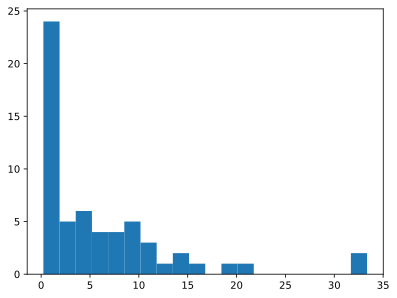

In [22]:
## actualy can just do end - start for any interval set

plt.hist(lick_epoch.end- lick_epoch.start,bins=20)

In [29]:
# ## randomized lick events

# ## plt 3 mice lick events together
# bin_size = 0.125

# fig, axes = plt.subplots(nrows=len(mouse_switch_set),ncols=2,figsize=[6,6],sharex='col')

# Ts_lick = nap.Ts(L1_timestamps_new) # for tref this needs to be nap.Ts object
# Ts_lick_random = nap.shift_timestamps(Ts_lick, min_shift=1, max_shift=20)

# for i in mouse_switch_set.index[:]:
#     peth = nap.compute_perievent(Ts_lick_random,tref=nap.Ts(lick_epoch.start).restrict(mouse_switch_set[i]),minmax=(-5,10))
#     # if we want to plot with sorting
#     sort_idx = np.argsort([len(peth[i]) for i in peth.index])
#     for order, idx in enumerate(sort_idx):
#         axes[i,0].eventplot(peth[idx].t,lineoffsets=order,linewidths=1,linelengths=0.8)
#     # axes[i,0].plot(peth.to_tsd(), "|")  # if plotting without sorting

#     sns.despine(ax=axes[i,0])
#     axes[i,1].plot(peth.count(bin_size).smooth(bin_size*2)/bin_size,alpha=0.2,c='grey',lw=1)
#     axes[i,1].plot((peth.count(bin_size).smooth(bin_size*2)/bin_size).mean(axis=1),label=f'{mice_list[i]}',c='k')
#     axes[i,1].legend(loc=2,frameon=False)
#     sns.despine(ax=axes[i,1])
#     axes[i,0].set_ylabel('trials (sorted)')
#     axes[i,1].set_ylabel('licks/s')
    
# axes[0,0].set_title('lick bouts')
# axes[0,1].set_title('lick rates')
# axes[i,0].set_xlabel('time from lick bout onset (s)')
# axes[i,1].set_xlabel('time from lick bout onset (s)')
# plt.tight_layout()